In [43]:
import numpy as np

# データの読み込み
file_path = 'processed_data_hybrid/all_data_combined.npz'
data = np.load(file_path, allow_pickle=True)

# 保存されているデータのキーを確認
print("Keys:", data.files)

# カラム名を表示（何番目が何のデータか確認するため）
cols = data['columns']
print(f"\n--- Column Names (Total: {len(cols)}) ---")
for i, col in enumerate(cols):
    print(f"{i}: {col}")

# データの形状確認
ensemble = data['ensemble']
subject_ids = data['subject_ids']

print("\nEnsemble Shape:", ensemble.shape)     # (サンプル数, 時間, 特徴量)
print("Subject IDs Shape:", subject_ids.shape) # (サンプル数,)

Keys: ['ensemble', 'subject_ids', 'columns', 'id_map']

--- Column Names (Total: 26) ---
0: Pressure_1
1: Pressure_2
2: Pressure_3
3: Pressure_4
4: Pressure_5
5: Pressure_6
6: Pressure_7
7: Pressure_8
8: Accel_X
9: Accel_Y
10: Accel_Z
11: Gyro_X
12: Gyro_Y
13: Gyro_Z
14: Hip_XY
15: Hip_YZ
16: Hip_ZX
17: Knee_XY
18: Knee_YZ
19: Knee_ZX
20: Ankle_XY
21: Ankle_YZ
22: Ankle_ZX
23: Fx
24: Fy
25: Fz

Ensemble Shape: (13542, 200, 26)
Subject IDs Shape: (13542,)


In [44]:
import numpy as np

# 1. 入力(X)と正解(y)の切り出し
X_all = ensemble[:, :, :14]
y_all = ensemble[:, :, 23:]

# 2. 被験者IDごとの分割設定
# 全被験者のIDリストを取得
unique_subjects = np.unique(subject_ids)
print(f"全被験者ID: {unique_subjects}")

# --- ここで分割するIDを指定します ---
# 例: ID 10, 11 をテスト(完全未知)にする
test_sub_ids = [10, 11] 
# 例: ID 8, 9 を検証用(学習中に精度を見るための未知データ)にする
val_sub_ids  = [8, 9]   
# 残りを学習用にする
train_sub_ids = [0, 1, 2, 3, 4, 5, 6, 7]

print(f"\n--- Split Config ---")
print(f"Train IDs: {train_sub_ids}")
print(f"Val   IDs: {val_sub_ids}")
print(f"Test  IDs: {test_sub_ids}")

# 3. マスク作成とデータの抽出
# np.isin を使って、該当するIDのデータ位置(True/False)を取得します
train_mask = np.isin(subject_ids, train_sub_ids)
val_mask   = np.isin(subject_ids, val_sub_ids)
test_mask  = np.isin(subject_ids, test_sub_ids)

# データ分割実行
X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

print(f"\n--- Data Split Completed (Subject-wise) ---")
print(f"Train : X={X_train.shape}, y={y_train.shape}")
print(f"Val   : X={X_val.shape},   y={y_val.shape}")
print(f"Test  : X={X_test.shape},  y={y_test.shape}")

# 確認: データ混入がないかチェック
train_ids_check = np.unique(subject_ids[train_mask])
test_ids_check = np.unique(subject_ids[test_mask])
intersect = np.intersect1d(train_ids_check, test_ids_check)
if len(intersect) == 0:
    print("OK: 学習データとテストデータに重複する被験者はいません。")
else:
    print(f"WARNING: データ混入があります -> {intersect}")

全被験者ID: [ 0  1  2  3  4  5  6  7  8  9 10 11]

--- Split Config ---
Train IDs: [0, 1, 2, 3, 4, 5, 6, 7]
Val   IDs: [8, 9]
Test  IDs: [10, 11]

--- Data Split Completed (Subject-wise) ---
Train : X=(8671, 200, 14), y=(8671, 200, 3)
Val   : X=(2289, 200, 14),   y=(2289, 200, 3)
Test  : X=(2582, 200, 14),  y=(2582, 200, 3)
OK: 学習データとテストデータに重複する被験者はいません。


In [45]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# ---  Tensor化とDataLoaderの作成 ---

BATCH_SIZE = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensorへの変換関数 (float32にキャスト)
def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32)

# Numpy配列を直接Tensorに変換
X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)

X_val_tensor   = to_tensor(X_val)
y_val_tensor   = to_tensor(y_val)

X_test_tensor  = to_tensor(X_test)
y_test_tensor  = to_tensor(y_test)

# Datasetの作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader Ready ---")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")
print(f"Using device: {device}")


--- DataLoader Ready ---
Train batches: 17
Val   batches: 5
Test  batches: 6
Using device: cuda


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

class TimeSeriesCNNRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, output_dim, dropout_prob=0.3):
        super(TimeSeriesCNNRegression, self).__init__()
        
        # Padding='same' のために padding = kernel_size // 2 を設定
        pad = kernel_size // 2

        # --- 特徴抽出ブロック (Feature Extractor) ---
        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=pad),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            
            # Block 2
            nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            
            # Block 3
            nn.Conv1d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # --- 回帰ヘッド (Regressor Head) ---
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # x shape: (Batch, Time, Features) -> (Batch, Features, Time)
        x = x.permute(0, 2, 1)
        
        # CNN適用
        x = self.features(x)
        
        # 元の形状に戻す (Batch, Features, Time) -> (Batch, Time, Features)
        x = x.permute(0, 2, 1)
        
        # 全結合層で予測
        output = self.regressor(x)
        return output

In [47]:
class AdvancedBiLSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.3):
        super(AdvancedBiLSTMRegression, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_prob if num_layers > 1 else 0,
            bidirectional=True 
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        r_out, _ = self.lstm(x)
        r_out = self.layer_norm(r_out)
        output = self.fc(r_out)
        return output

In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # 位置エンコーディング行列の作成
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # (MaxLen, d_model) -> (1, MaxLen, d_model) バッチ次元追加
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: (Batch, SeqLen, d_model)
        # 入力シーケンス長に合わせてカットして加算
        x = x + self.pe[:, :x.size(1), :]
        return x


class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, output_dim, dropout_prob=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        self.output_dim = output_dim
        
        # 1. 入力埋め込み (Input -> d_model)
        self.embedding = nn.Linear(self.input_dim, self.d_model)
        
        # 2. 位置エンコーディング
        self.pos_encoder = PositionalEncoding(self.d_model)
        
        # 3. Transformer Encoder Layers
        # batch_first=True にすることで (Batch, Time, Feat) のまま扱える
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout_prob,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4. 出力層 (d_model -> Output)
        self.fc = nn.Sequential(
            nn.Linear(self.d_model, 64),
            nn.ReLU(),
            nn.Linear(64, self.output_dim)
        )

    def forward(self, x):
        # x shape: (Batch, Time, Input_Dim)
        
        # Embedding & Positional Encoding
        # scaling by sqrt(d_model) is often used in Transformer paper
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        # Transformer Encoder
        # Maskは不要（オフライン解析ですべての時刻を参照して良いため）
        r_out = self.transformer_encoder(x)
        
        # Output Projection
        output = self.fc(r_out)
        
        return output

In [49]:
# ---------------------------------------------------------
# 2. 推論・データ収集関数の定義
# ---------------------------------------------------------
import inspect  # これをインポートしてください

def load_model_and_predict(model_class, checkpoint_path, X_tensor, device):
    """
    チェックポイントをロードし、モデル定義に必要な引数だけを抽出して構築・予測を行う関数
    """
    # 1. チェックポイントのロード
    checkpoint = torch.load(checkpoint_path, map_location=device)
    full_config = checkpoint['config']
    state_dict = checkpoint['model_state_dict']
    
    print(f"--- Loading {checkpoint_path} ---")

    # 2. キー名の修正 (前回のdropout対応など)
    # 必要に応じて辞書をコピーして元のconfigを汚さないようにする
    model_config = full_config.copy()
    
    # 'dropout' -> 'dropout_prob' の修正
    if 'dropout' in model_config:
        model_config['dropout_prob'] = model_config.pop('dropout')
    
    # Transformer用の修正 (hidden_dim -> d_model)
    if model_class.__name__ == 'TimeSeriesTransformer':
        if 'hidden_dim' in model_config and 'd_model' not in model_config:
             model_config['d_model'] = model_config.pop('hidden_dim')

    # 3. 【重要】モデルの引数を調査し、必要なものだけを抽出する (フィルタリング)
    # モデルの __init__ が受け取る引数リストを取得
    sig = inspect.signature(model_class.__init__)
    valid_keys = set(sig.parameters.keys())
    
    # configの中から、モデルが必要としているキーだけを取り出す
    filtered_config = {k: v for k, v in model_config.items() if k in valid_keys}
    
    # どのキーが採用され、どれが無視されたか確認用（デバッグ）
    ignored_keys = set(model_config.keys()) - set(filtered_config.keys())
    if ignored_keys:
        print(f"  Ignored config keys (not in model __init__): {ignored_keys}")

    # 4. モデル構築と予測
    try:
        model = model_class(**filtered_config).to(device)
    except TypeError as e:
        print(f"  [Error] Still failing to initialize {model_class.__name__}.")
        print(f"  Passed keys: {list(filtered_config.keys())}")
        raise e

    model.load_state_dict(state_dict)
    model.eval()
    
    with torch.no_grad():
        X_tensor = X_tensor.to(device)
        preds = model(X_tensor)
    
    return preds.cpu().numpy()

In [50]:
# ---------------------------------------------------------
# 3. 実行とデータの準備
# ---------------------------------------------------------

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# パス設定 (保存したファイル名に合わせてください)
path_cnn = 'cnn_both_normal.pth'
path_lstm = 'bilstm_both_normal.pth'
path_trans = 'transformer_both_normal.pth'

# --- 予測の実行 ---
# X_test_tensor はご提示のコードで作成済みのものを使用
print("Predicting with 1D-CNN...")
pred_cnn = load_model_and_predict(TimeSeriesCNNRegression, path_cnn, X_test_tensor, device)

print("Predicting with BiLSTM...")
pred_lstm = load_model_and_predict(AdvancedBiLSTMRegression, path_lstm, X_test_tensor, device)

print("Predicting with Transformer...")
pred_trans = load_model_and_predict(TimeSeriesTransformer, path_trans, X_test_tensor, device)

# --- 正解データ (Ground Truth) ---
# y_test_tensor も作成済みのものを使用
true_data = y_test_tensor.numpy()

Predicting with 1D-CNN...
--- Loading cnn_both_normal.pth ---
  Ignored config keys (not in model __init__): {'batch_size', 'lr', 'loss_weights', 'patience', 'epochs', 'factor', 'device'}
Predicting with BiLSTM...


--- Loading bilstm_both_normal.pth ---
  Ignored config keys (not in model __init__): {'batch_size', 'lr', 'loss_weights', 'patience', 'epochs', 'factor', 'device'}
Predicting with Transformer...
--- Loading transformer_both_normal.pth ---
  Ignored config keys (not in model __init__): {'batch_size', 'lr', 'loss_weights', 'patience', 'epochs', 'factor', 'device'}


In [51]:
# ---------------------------------------------------------
# 4. 統計量の算出 (Mean, SD, RMSE, NRMSE)
# ---------------------------------------------------------

# --- A. 正解データ (Ground Truth) の分析 ---
# 平均と標準偏差 (波形プロット用)
mean_true = np.mean(true_data, axis=0)
std_true  = np.std(true_data, axis=0)

# データのレンジ (NRMSE計算用: 最大値 - 最小値)
# axis=(0, 1) -> 全サンプル・全時刻を通じた各軸のMax/Min
data_max = np.max(true_data, axis=(0, 1))
data_min = np.min(true_data, axis=(0, 1))
data_range = data_max - data_min

# ゼロ除算回避
data_range[data_range == 0] = 1.0
print(f"Data Range (Fx, Fy, Fz): {data_range}")


# --- B. 予測データ (Predictions) の平均 ---
# 波形プロット用
mean_cnn   = np.mean(pred_cnn, axis=0)
mean_lstm  = np.mean(pred_lstm, axis=0)
mean_trans = np.mean(pred_trans, axis=0)


# --- C. 誤差 (RMSE & NRMSE) の算出 ---
# 関数定義: RMSEとNRMSEをまとめて計算
def calculate_errors(pred, true, d_range):
    # RMSE: √ ( 平均( (予測 - 正解)^2 ) ) -> (Time, Channels)
    rmse = np.sqrt(np.mean((pred - true)**2, axis=0))
    # NRMSE: (RMSE / Range) * 100 -> [%]
    nrmse = (rmse / d_range) * 100
    return rmse, nrmse

# 各モデルの誤差を計算
rmse_cnn,   nrmse_cnn   = calculate_errors(pred_cnn,   true_data, data_range)
rmse_lstm,  nrmse_lstm  = calculate_errors(pred_lstm,  true_data, data_range)
rmse_trans, nrmse_trans = calculate_errors(pred_trans, true_data, data_range)


# --- D. 時間軸の作成 ---
time_steps = mean_true.shape[0]
x_axis = np.linspace(0, 100, time_steps)

print("Statistics calculated: Means, SDs, RMSEs, and NRMSEs are ready.")

Data Range (Fx, Fy, Fz): [0.25228983 0.68480796 1.7609894 ]
Statistics calculated: Means, SDs, RMSEs, and NRMSEs are ready.


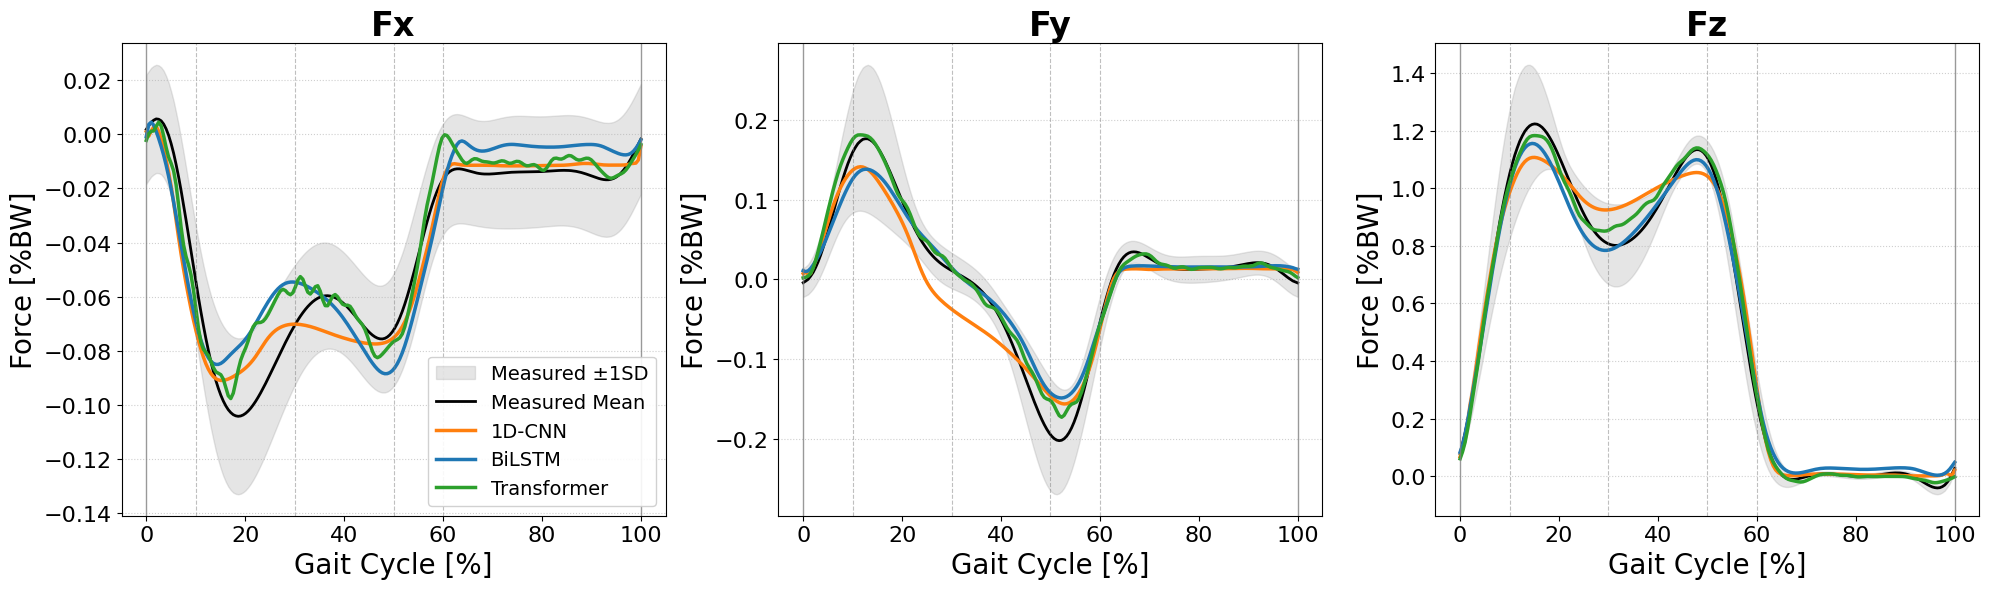

In [ ]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 5. 可視化設定 (Configuration)
# ---------------------------------------------------------

# --- フォントサイズ設定 ---
FS_TITLE  = 24  # タイトル 
FS_LABEL  = 20  # 軸ラベル 
FS_TICK   = 16  # 目盛り数値
FS_LEGEND = 14  # 凡例

# --- 線の太さ (Line Width) ---
LW_TRUE = 2.0   # 実測値（平均）の太さ
LW_PRED = 2.5   # 予測モデルの線の太さ

# --- 色設定 (Colors) ---
C_TRUE  = 'black'        # 実測値
C_SD    = 'gray'         # 標準偏差の帯
C_CNN   = 'tab:orange'   # CNN
C_LSTM  = 'tab:blue'     # BiLSTM
C_TRANS = 'tab:green'    # Transformer

# --- 透明度 (Alpha) ---
ALPHA_SD = 0.2           # 標準偏差帯の透明度

# --- 図全体のサイズ ---
FIG_SIZE = (20, 6)

# --- ラベル定義 ---
TITLES = ['Fx', 'Fy', 'Fz']
LABEL_X = 'Gait Cycle [%]'
LABEL_Y = 'Force [%BW]'

# フェーズ情報の再定義
PHASES = {
    'LR':  (0, 10),
    'MSt': (10, 30),
    'TSt': (30, 50),
    'PSw': (50, 60),
    'Sw':  (60, 100)
}
PHASE_NAMES = list(PHASES.keys())

# 座標とラベルの計算
x_midpoints = []
phase_boundaries = [0] 

for start, end in PHASES.values():
    mid = (start + end) / 2
    x_midpoints.append(mid)
    phase_boundaries.append(end)

phase_labels = [f"{name}" for name, (s, e) in PHASES.items()]


# ---------------------------------------------------------
# 2. プロット実行
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE, sharey=False)

# 3つの成分 (Fx, Fy, Fz) についてループ
for i in range(3):
    ax = axes[i]
    
    # --- A. 正解データ (Measured) ---
    # ±1SD (グレーの塗りつぶし)
    # ※ 線より先に描画することで、線が帯の上にくるようにします
    ax.fill_between(x_axis, 
                    mean_true[:, i] - std_true[:, i], 
                    mean_true[:, i] + std_true[:, i], 
                    color=C_SD, alpha=ALPHA_SD, label='Measured ±1SD')

    # 平均値 (黒線)
    ax.plot(x_axis, mean_true[:, i], color=C_TRUE, linewidth=LW_TRUE, label='Measured Mean')
    
    # --- B. モデル予測 (Predictions) ---
    # 1D-CNN
    ax.plot(x_axis, mean_cnn[:, i], color=C_CNN, linewidth=LW_PRED, label='1D-CNN')
    
    # BiLSTM
    ax.plot(x_axis, mean_lstm[:, i], color=C_LSTM, linewidth=LW_PRED, label='BiLSTM')
    
    # Transformer
    ax.plot(x_axis, mean_trans[:, i], color=C_TRANS, linewidth=LW_PRED, label='Transformer')

    # --- フェーズ区切り線の描画 ---
    # 0% と 100% も含めて線を描画
    for b in phase_boundaries:
        # 0と100は実線(少し太く)、それ以外は点線にするなどの工夫
        ls = '-' if b in [0, 100] else '--'
        lw = 1.0 if b in [0, 100] else 0.8
        alpha = 0.8 if b in [0, 100] else 0.5
        ax.axvline(x=b, color='gray', linestyle=ls, linewidth=lw, alpha=alpha)
    
    # --- C. 装飾 (Styling) ---
    ax.set_title(TITLES[i], fontsize=FS_TITLE, fontweight='bold')
    ax.set_xlabel(LABEL_X, fontsize=FS_LABEL)
    ax.set_ylabel(LABEL_Y, fontsize=FS_LABEL)
    
    # 目盛りの文字サイズ設定
    ax.tick_params(axis='both', which='major', labelsize=FS_TICK)
    
    # # グリッド
    ax.grid(axis='y', linestyle=':', alpha=0.6)
    
    # 凡例 (最初のグラフのみ表示)
    if i == 0:
        ax.legend(loc='lower right', fontsize=FS_LEGEND, framealpha=0.9)

plt.tight_layout()
plt.show()

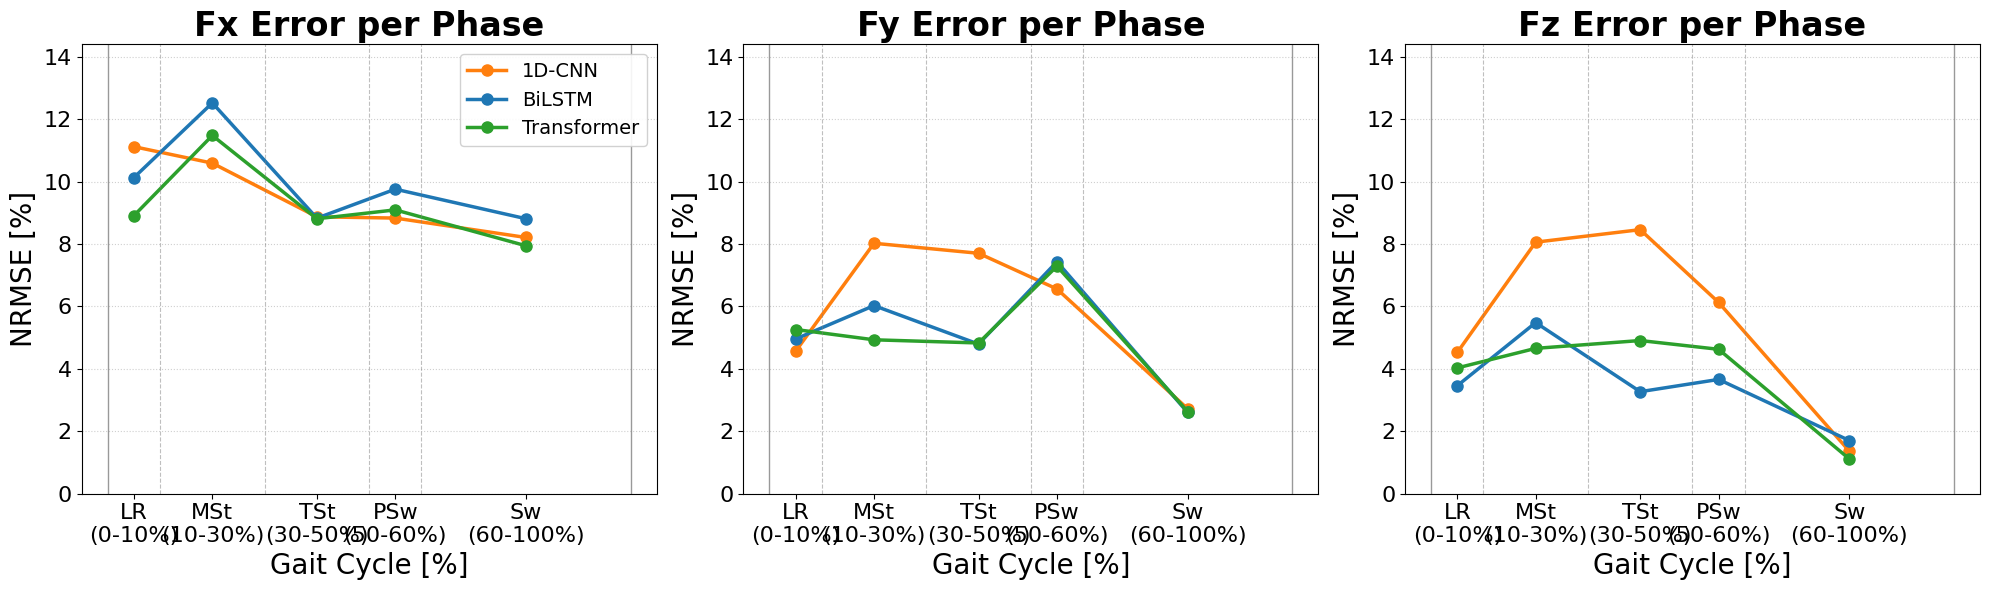

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. 準備 (前回と同じ設定)
# ---------------------------------------------------------
# デザイン設定
FS_TITLE  = 24  # タイトル (Fx, Fy, Fz)
FS_LABEL  = 20  # 軸ラベル (Gait Cycle, Force)
FS_TICK   = 16  # 目盛り数値
FS_LEGEND = 14  # 凡例
LW_LINE   = 2.5
MARKER_SIZE = 8

C_CNN   = 'tab:orange'
C_LSTM  = 'tab:blue'
C_TRANS = 'tab:green'

TITLES = ['Fx Error per Phase', 'Fy Error per Phase', 'Fz Error per Phase']
LABEL_Y = 'NRMSE [%]'
LABEL_X = 'Gait Cycle [%]'
FIG_SIZE = (20, 6)

# フェーズ情報の再定義
PHASES = {
    'LR':  (0, 10),
    'MSt': (10, 30),
    'TSt': (30, 50),
    'PSw': (50, 60),
    'Sw':  (60, 100)
}
PHASE_NAMES = list(PHASES.keys())

# 座標とラベルの計算
x_midpoints = []
phase_boundaries = [0] 

for start, end in PHASES.values():
    mid = (start + end) / 2
    x_midpoints.append(mid)
    phase_boundaries.append(end)

phase_labels = [f"{name}\n({s}-{e}%)" for name, (s, e) in PHASES.items()]

# ---------------------------------------------------------
# 2. プロット実行
# ---------------------------------------------------------
# Y軸の最大値決定
all_values = []
for m in [means_cnn, means_lstm, means_trans]:
    for v in m.values():
        all_values.append(v)
y_max = np.max(np.array(all_values)) * 1.15

fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE, sharey=False)

for i in range(3):
    ax = axes[i]
    
    # データ準備
    vals_cnn   = [means_cnn[p][i]   for p in PHASE_NAMES]
    vals_lstm  = [means_lstm[p][i]  for p in PHASE_NAMES]
    vals_trans = [means_trans[p][i] for p in PHASE_NAMES]
    
    # --- 折れ線グラフ ---
    ax.plot(x_midpoints, vals_cnn,   color=C_CNN,   linewidth=LW_LINE, marker='o', markersize=MARKER_SIZE, label='1D-CNN')
    ax.plot(x_midpoints, vals_lstm,  color=C_LSTM,  linewidth=LW_LINE, marker='o', markersize=MARKER_SIZE, label='BiLSTM')
    ax.plot(x_midpoints, vals_trans, color=C_TRANS, linewidth=LW_LINE, marker='o', markersize=MARKER_SIZE, label='Transformer')
    
    # --- フェーズ区切り線の描画 ---
    # 0% と 100% も含めて線を描画
    for b in phase_boundaries:
        # 0と100は実線(少し太く)、それ以外は点線にするなどの工夫
        ls = '-' if b in [0, 100] else '--'
        lw = 1.0 if b in [0, 100] else 0.8
        alpha = 0.8 if b in [0, 100] else 0.5
        ax.axvline(x=b, color='gray', linestyle=ls, linewidth=lw, alpha=alpha)
    
    # --- 装飾 ---
    ax.set_title(TITLES[i], fontsize=FS_TITLE, fontweight='bold')
    ax.set_xlabel(LABEL_X, fontsize=FS_LABEL)
    ax.set_ylabel(LABEL_Y, fontsize=FS_LABEL)
    
    # X軸目盛り設定
    ax.set_xticks(x_midpoints)
    ax.set_xticklabels(phase_labels, fontsize=FS_TICK)
    
    # Y軸設定
    ax.set_ylim(0, y_max)
    ax.tick_params(axis='y', labelsize=FS_TICK)
    ax.grid(axis='y', linestyle=':', alpha=0.6)
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=FS_LEGEND, framealpha=0.9)

plt.tight_layout()
plt.show()